In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
from skimage import draw
from topostats.theme import Colormap
import math

In [2]:
cmap = Colormap("nanoscope").get_cmap()

def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Tue, 16 May 2023 12:02:02] [INFO    ] [topostats] Extracting image from EP_Zoom\20230419_EPN005_Metal.0_00006.spm
[Tue, 16 May 2023 12:02:02] [INFO    ] [topostats] Loading image from : EP_Zoom\20230419_EPN005_Metal.0_00006.spm
[Tue, 16 May 2023 12:02:02] [INFO    ] [topostats] [20230419_EPN005_Metal.0_00006] : Loaded image from : EP_Zoom\20230419_EPN005_Metal.0_00006.spm
[Tue, 16 May 2023 12:02:02] [INFO    ] [topostats] [20230419_EPN005_Metal.0_00006] : Extracted channel Height
[Tue, 16 May 2023 12:02:02] [INFO    ] [topostats] [20230419_EPN005_Metal.0_00006] : Pixel to nm scaling : 3.2958984375


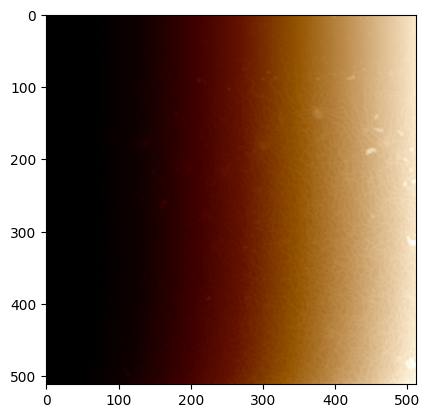

In [3]:
#Import SPM files
#file = Path('./PristineZoom/20230125_KPN005_25mMMgCl2_Vac.0_00009.spm')
#file = Path('./PristineZoom/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm')
file = Path('./EP_Zoom/20230419_EPN005_Metal.0_00006.spm')

loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw, cmap=cmap)

In [4]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    row_alignment_quantile=0.05,
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Tue, 16 May 2023 12:02:08] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Metal.0_00006.spm] : Median flattening without mask
[Tue, 16 May 2023 12:02:09] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Metal.0_00006.spm] : Plane tilt removal without mask
[Tue, 16 May 2023 12:02:09] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Metal.0_00006.spm] : x-polyfit 1st order: [ 0.1566121  -4.27601921]
[Tue, 16 May 2023 12:02:09] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Metal.0_00006.spm] : y-polyfit 1st order: [-9.59394027e-05  3.55478110e+01]
[Tue, 16 May 2023 12:02:09] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Metal.0_00006.spm] : Removing x plane tilt
[Tue, 16 May 2023 12:02:09] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Metal.0_00006.spm] : removing y plane tilt
[Tue, 16 May 2023 12:02:09] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Metal.0_00006.spm] : Remove quadratic bow without mask
[Tue, 16 May 2023 12:02:09] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Me

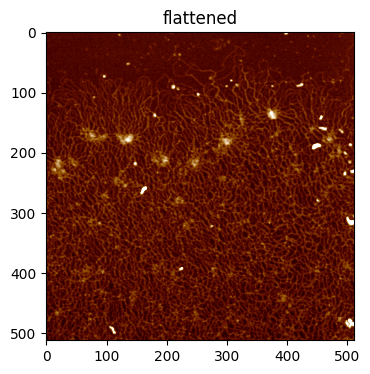

262144


In [11]:
flattened = filters.images['zero_average_background']
plot(flattened, title='flattened',figsize=(4,4))

thresholds: defaultdict(None, {'upper': 1.8114183740908996})
[Tue, 16 May 2023 12:02:17] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 1.8114183740908996


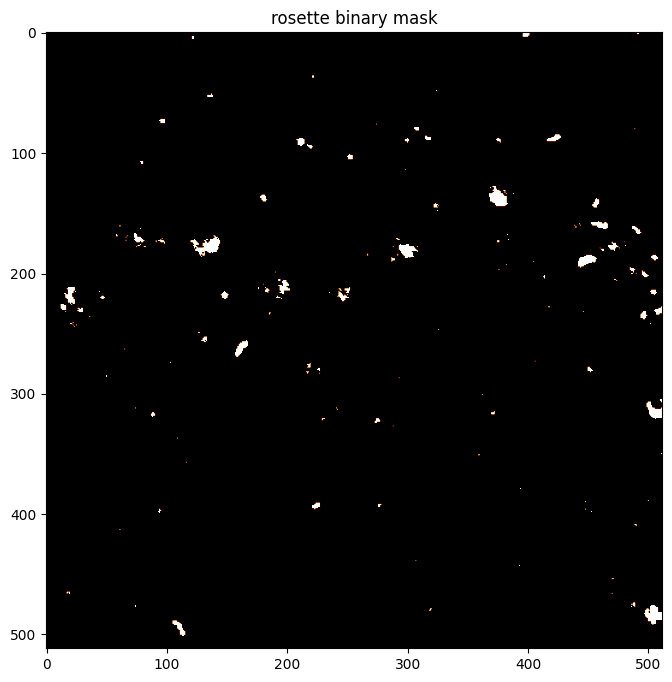

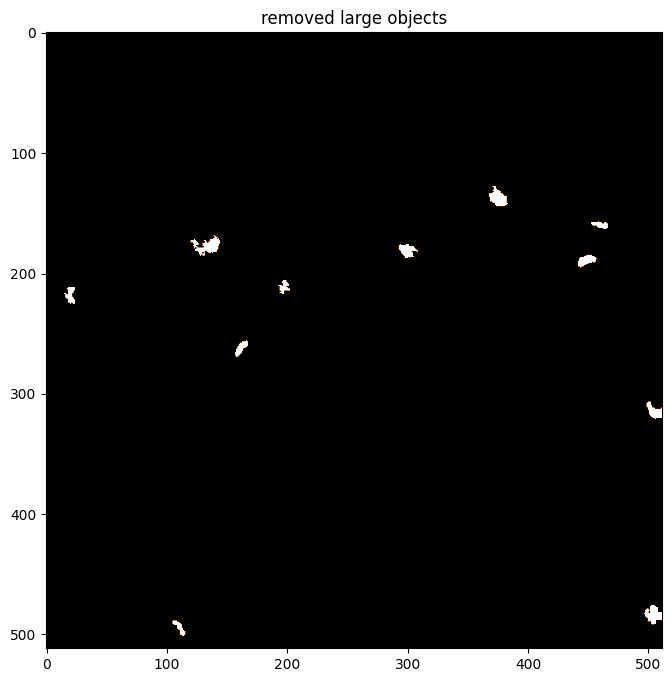

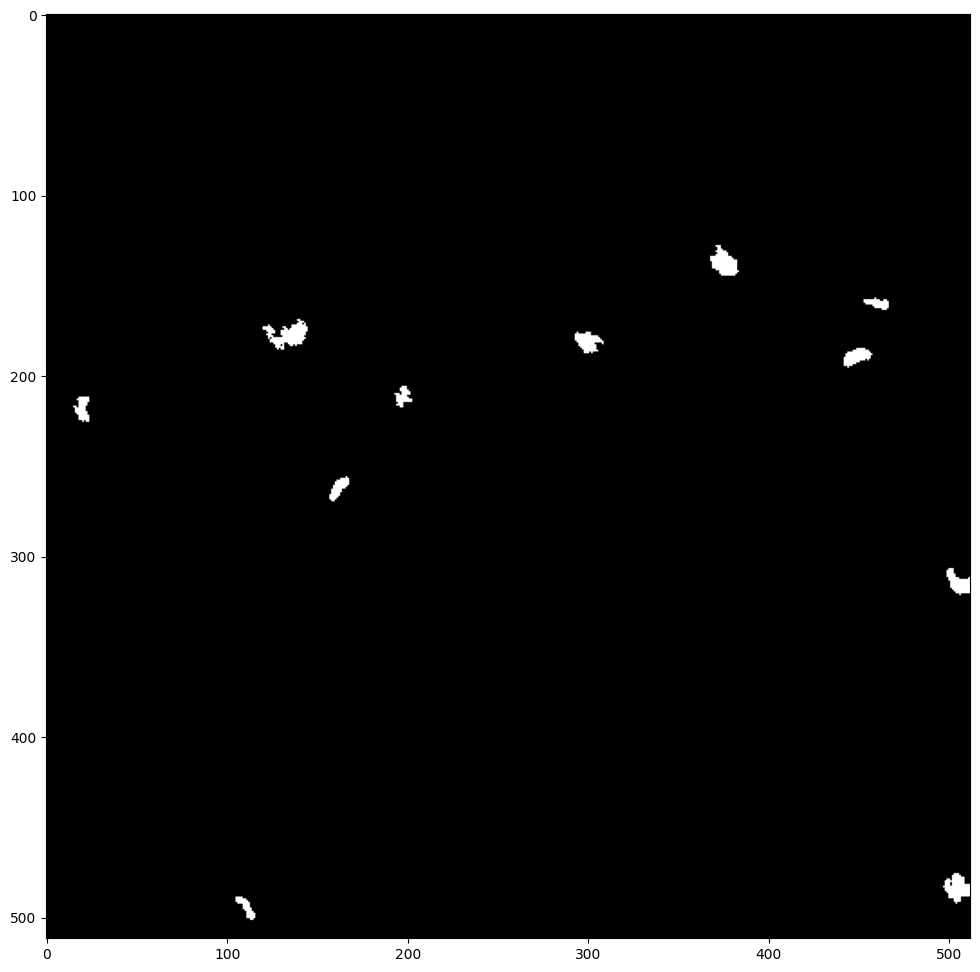

In [6]:
#Locate Nodes

rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 3, 'lower': None}
)

print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, 50)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 750:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


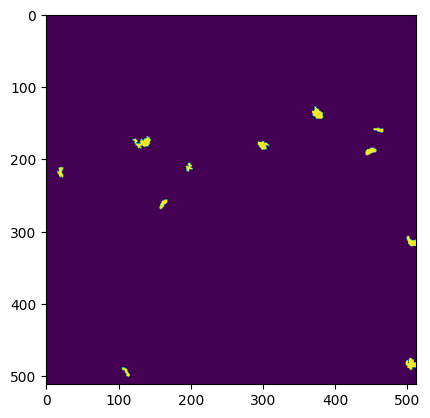

In [7]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()
import network_stats
dir(network_stats)
#Find node centroid coordinates
node_centroids = network_stats.get_node_centroids(labelled_rosette_mask)
#Find node areas
node_areas = network_stats.node_stats(labelled_rosette_mask, flattened)["node areas"]

43.0
41.0
45.0
58.0
38.0
42.0
44.0
Average strand coordination: 16.571428571428573
Peak Areas: [[30.7847056582629, 0.01656248247754833, 0.22665917416109171, 7.8836033289014225, 1.7535794922001626, 0.9974376417959392, 2.5825062605713436, 1.7536094330233367, 4.724502341631332, 0.2403798931597101, 1.5260463763229914, 10.828932748625983, 0.3895547644301883, 6.464119079992866, 3.821486901284634, 4.8873134483203, 1.4986757530970323, 1.8405391617013755, 1.4852278309782776], [0.6195400172557444, 5.185918414653049, 16.654628084497958, 0.17545224825452652, 0.8071704080527191, 16.474541659377458, 2.02962899309135, 0.408493304400522, 1.2104619600652367, 1.0268152980775316, 0.06907143640347481, 4.929676554097285, 3.964149831955369, 0.24338461363300526, 1.1345501541783638, 3.5955601793470935, 156.1479537156175], [7.181726408318834, 3.1527494391834927, 3.0732517720479104, 0.6100887001350236, 2.9654097827801458, 3.6116296956453184, 0.9818911411477681, 1.2896180877574213, 3.0169495563759403, 1.95210297

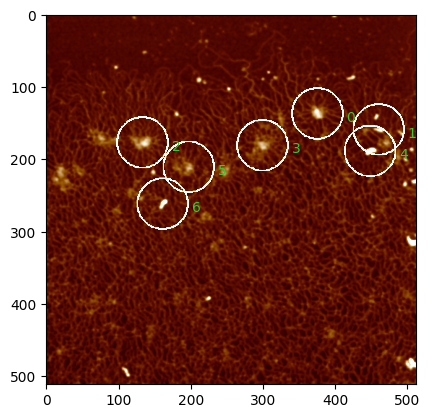

C:\Users\bdigg\AppData\Local\Temp\ipykernel_2708\3512520181.py:84: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(subsection, vmin=-3, vmax=4, cmap=cmap)


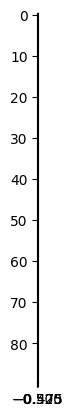

In [15]:
#Create circular masks around each nodes and extract heights

circle_mask = gaussian(flattened.copy(), sigma=1.0) #Copy of flattened for gathering heights with small gaussian blur to regulate values
circle_image = circle_mask #Create second mask for drawing on 
im_width = math.sqrt(circle_mask.size)

radius =  35
circ_nm = radius*2*np.pi*p_to_nm #circumference of masked circle in nm
region_values,included,area_tot,counts,region_peakarea,branch_counts,strands_count_all,node_area_cut = [],[],[],[],[],[],[],[]

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# need a list of centroids of the circles that satisfy
# the conditions, so we can label them in the image
# iteratively
filtered_circle_centroids = []
for k, centroid in enumerate(node_centroids):
   
    rr,cc = draw.circle_perimeter(int(centroid[0]), int(centroid[1]), radius, method='bresenham')
    inc_nm = circ_nm/len(rr) #spacing between pixels

    if any((i<0 or i>im_width) for i in rr) or any((j<0 or j>im_width) for j in cc):
        None #Ignores points outside of the surveyed region
    else:  
        #separates rr,cc into XY pairs
        XY = [i for i in zip(rr,cc)]
        # Sort the points based on their angles around the centroid
        indices = ((np.argsort([angle(point, centroid) for point in XY])))
        sorted,rr_sort,cc_sort = [],[],[]
        for i in indices:
            sorted.append(XY[i])
        for j in sorted:
            rr_sort.append(j[0])
            cc_sort.append(j[1])
        #Extracts perimeter values
        perimeter_values = circle_mask[rr_sort,cc_sort]
        perimeter_strands = np.clip(circle_mask[rr_sort,cc_sort]-0.25,0,1000)

        #Scans around the mask, identifiying peaks, calcualting area and estimating number of strands
        prev,count,trparea = 0,0,0
        peak_areas, strand_count = [],[]
        for height in perimeter_strands:
            if height > 0 and prev >= 0:
                trparea = trparea + 0.5*(height-prev)*inc_nm + prev*inc_nm 
            elif height == 0 and prev > 0:
                trparea = trparea + 0.5*(height-prev)*inc_nm + prev*inc_nm
                peak_areas.append(trparea)
                if trparea < 30:
                    strand = math.ceil(trparea/(math.sqrt(trparea)*0.75))
                    strand_count= np.append(strand_count, strand)
                trparea = 0
            prev = height
        branch_count = len(peak_areas)
        strands_count_all = np.append(strands_count_all,strand_count)
        print(sum(strand_count))

        #Appends branch/strand data to list from all nodes
        branch_counts= np.append(branch_counts,branch_count)
        region_peakarea.append(peak_areas)
        region_values.append(perimeter_values)
        node_area_cut.append(node_areas[k])

        circle_image[rr_sort,cc_sort] = 100
        area_tot = np.trapz(region_values,dx=5)
        #print("Area:",area_tot)


        filtered_circle_centroids.append(centroid)
print("Average strand coordination:",(sum(branch_counts)/len(branch_counts)) )
#print("Average branch coordination:",(sum(strands_count_all)/len(strands_count_all)))
#print(strands_count_all)
#print(node_area_cut)
print("Peak Areas:",region_peakarea)

plt.imshow(circle_image, vmin=-3, vmax=4, cmap=cmap)
for index, centroid in enumerate(filtered_circle_centroids):
    plt.text(centroid[1]+40, centroid[0]+10, f'{index}', color='limegreen')
plt.show()

subsection = circle_image[0:90, 825:960]
plt.imshow(subsection, vmin=-3, vmax=4, cmap=cmap)
plt.show()



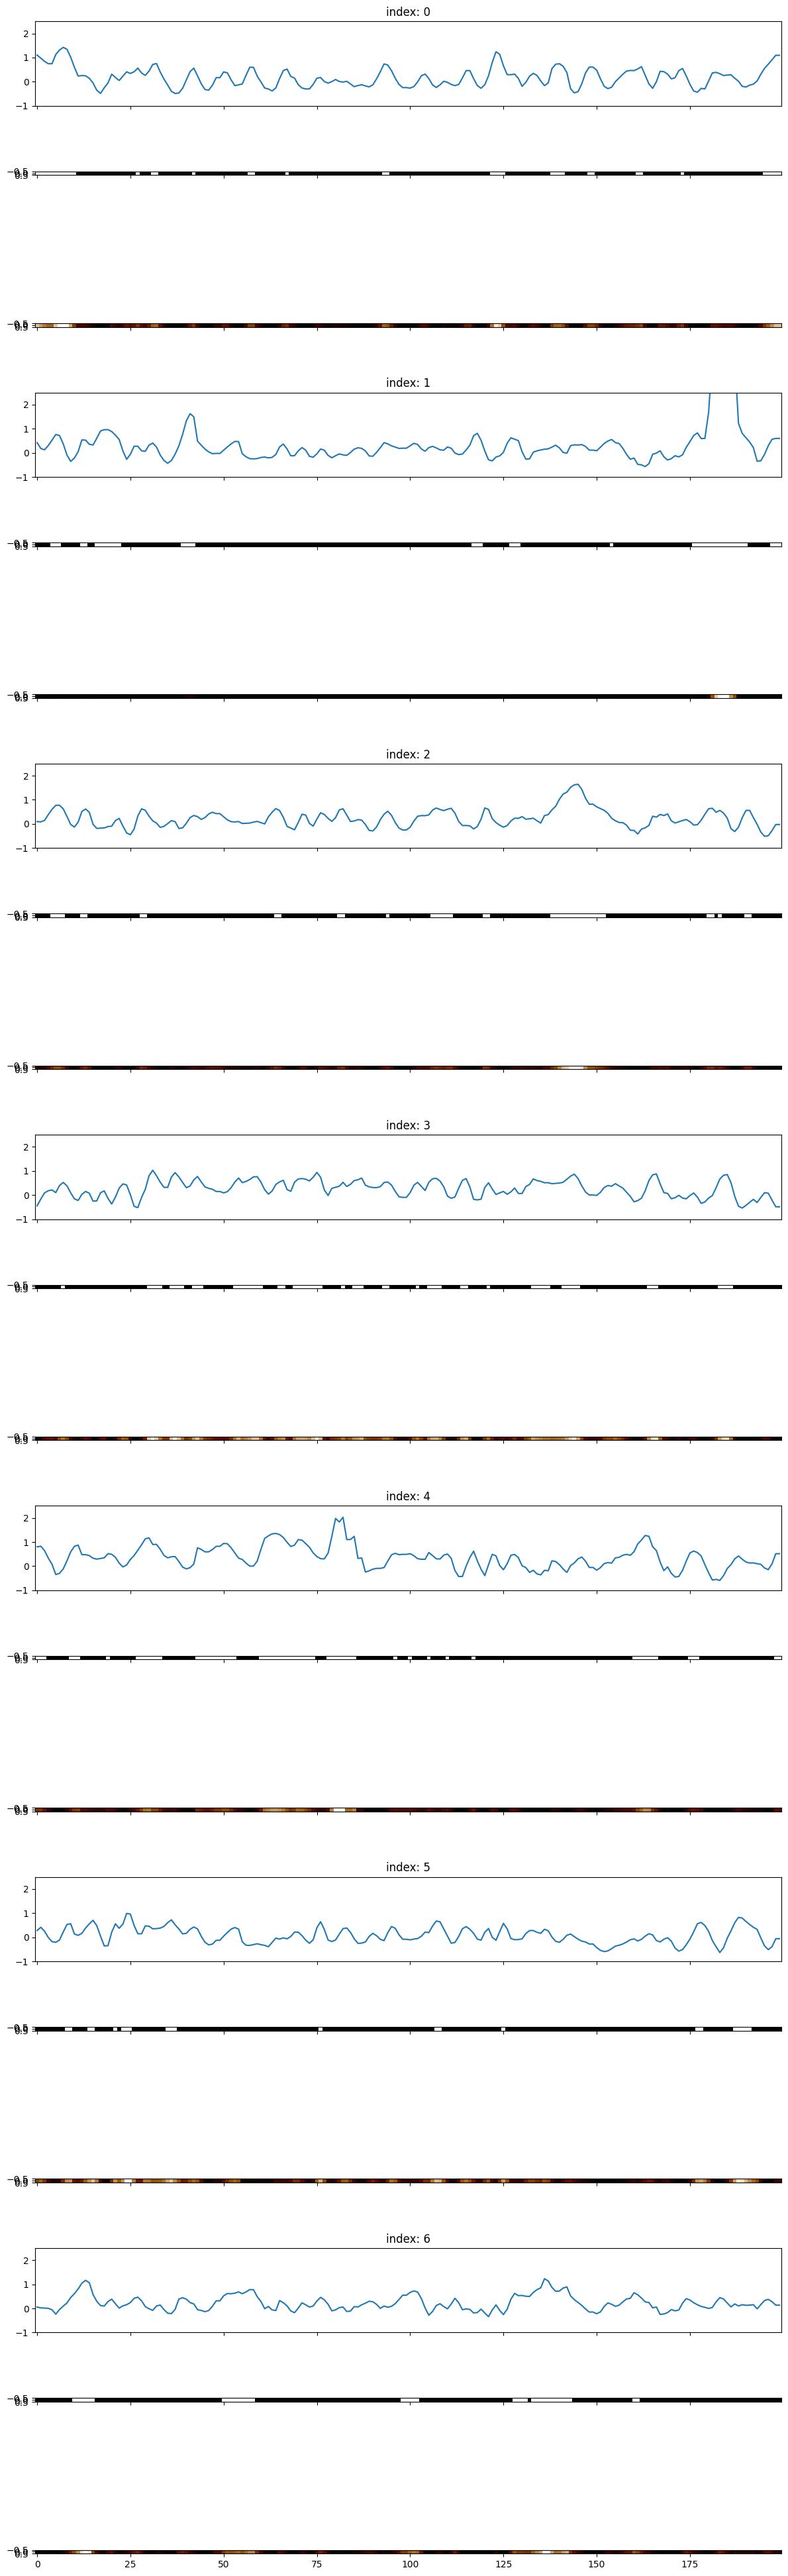

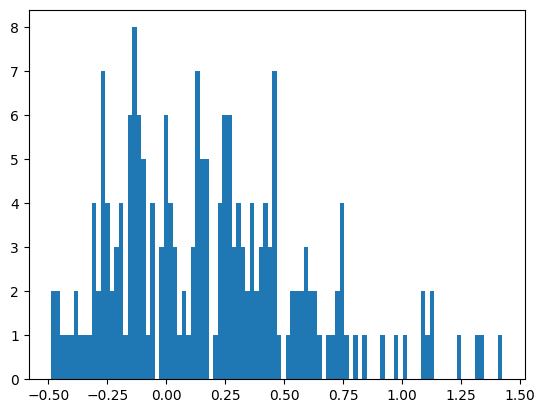

"\n#Single plot\ni = 0\nvalues = region_values[0]\nfor j in values:\n    print(j)\nfor k,point in enumerate(values):\n    print(inc_nm*k)\nfig, ax = plt.subplots(3,1,figsize=(12, 3), sharex=True)\nax[0].set_ylim(-1, 2.5)\nax[0].plot(values)\nax[1].imshow(np.array([values > 0.5]), cmap=cmap)\nax[2].imshow(np.array([values]), cmap=cmap)\nax[0].set_title(f'index: {i}')\nfig.tight_layout()\nplt.show()\n#"

In [10]:
#Plot height trace with pixels and estimated branch widths

height_ratios = [1, 2, 2]*len(region_values)
fig, ax = plt.subplots(len(region_values*3),1,figsize=(12, 40), sharex=True, gridspec_kw={'height_ratios': height_ratios})
for i, values in enumerate(region_values):
    ax[i*3].set_ylim(-1, 2.5)
    ax[i*3].plot(values)
    ax[i*3+1].imshow(np.array([values > 0.5]), cmap=cmap)
    ax[i*3+2].imshow(np.array([values]), cmap=cmap)
    ax[i*3].set_title(f'index: {i}')
fig.tight_layout()
plt.show()
index = 0
values = region_values[index]
fig, ax = plt.subplots()
ax.hist(values, bins=100)
plt.show()
"""
#Single plot
i = 0
values = region_values[0]
for j in values:
    print(j)
for k,point in enumerate(values):
    print(inc_nm*k)
fig, ax = plt.subplots(3,1,figsize=(12, 3), sharex=True)
ax[0].set_ylim(-1, 2.5)
ax[0].plot(values)
ax[1].imshow(np.array([values > 0.5]), cmap=cmap)
ax[2].imshow(np.array([values]), cmap=cmap)
ax[0].set_title(f'index: {i}')
fig.tight_layout()
plt.show()
#"""